# Cut-replace rate: how much is a sentence cut vs. replaced

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_2


Imports for the analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from pandas import DataFrame
from scipy.stats import linregress
import seaborn as sb

from gists.models import Sentence, Tree

from analysis.utils import grouper, memoized, mpl_palette

## 2 Cut-replace rate per tree

First build our data

In [4]:
trees = Tree.objects.experiment.all()
data = []
order = []
for tree in trees:
    root = tree.root
    order.append({'tree id': tree.id,
                  'root_content_words_count': len(root.content_words)})
    for sentence in tree.sentences.kept.all():
        data.append({'tree id': tree.id,
                     'sentence id': sentence.id,
                     'length': len(sentence.content_words),
                     'length / len(root)': len(sentence.content_words) / len(root.content_words),
                     'diff from root': root.uc_distance(sentence)
                    })
data = DataFrame(data)
root_order = DataFrame(order).sort_values(['root_content_words_count', 'tree id'])

For each tree, plot the length of a sentence (number of content words relative to number content words of its tree root, so immune so minor changes) as a function of the difference from its tree root (difference taken as distance between bags of content words, so unordered).

On each plot there are 3 interesting spots:
* a sentence in the upper-left is very close to the root, both in length and content;
* a sentence in the upper-right is very different to the root, but about the same length; so it's different from its root, because many words are replaced;
* a sentence in the lower-right is very different to the root, and a lot shorter too; so it's different mainly because it's been croppped a lot.

So, the steeper the slope (downwards), the more a tree has its sentences cut, i.e. words removed. The flatter the slope, the more it has its sentences transformed, i.e. words replaced.

Plots are **ordered by number of content words in the root of the tree**, which correlates a lot to the slope.

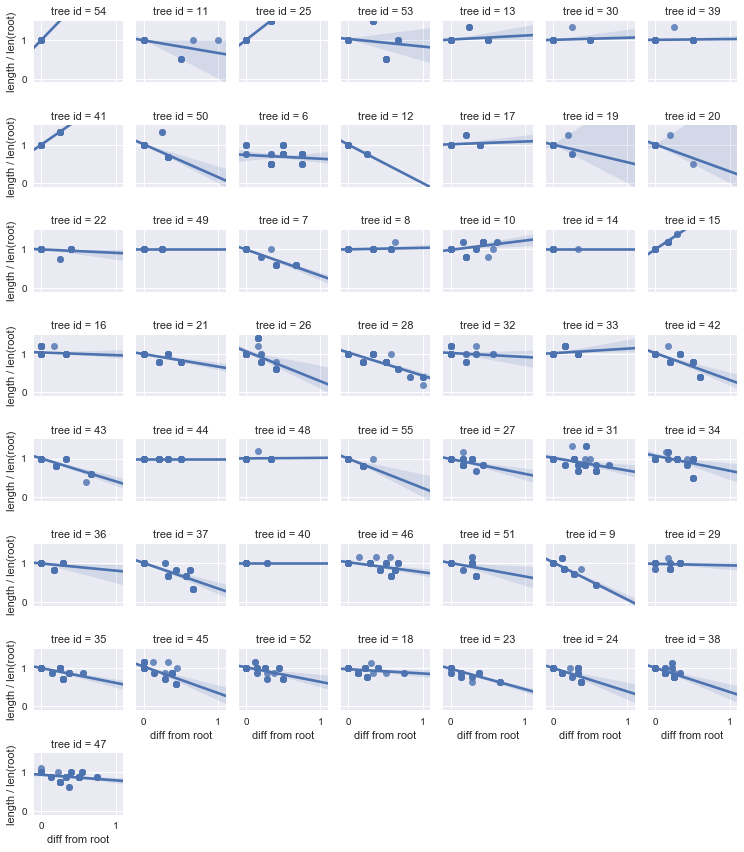

In [5]:
g = sb.lmplot(data=data,
              y='length / len(root)', x='diff from root',
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'])
g.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.5))
if SAVE_FIGURES:
    g.savefig(FIG.format('cut-replace_rate'), dpi=300)

Most trees seem to give flat or negative slope (i.e. the shorter the sentence, the more different it is from its root).

## 3 Cut-replace rate ~ number of initial content words, which seem closely related

First build our data

In [6]:
slope_content = []
for tree in Tree.objects.experiment.all():
    tree_data = data[data['tree id'] == tree.id]
    slope, intercept, r_value, p_value, std_err = linregress(tree_data['diff from root'],
                                                             tree_data['length / len(root)'])
    slope_content.append({'tree id': tree.id,
                          'root content words count': len(tree.root.content_words),
                          'slope': slope})
slope_content = DataFrame(slope_content)

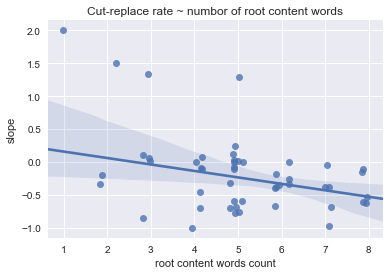

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sb.regplot(ax=ax, data=slope_content,
           x='root content words count', y='slope',
           x_jitter=.2, robust=True)
ax.set_title('Cut-replace rate ~ numbor of root content words')
if SAVE_FIGURES:
    fig.savefig(FIG.format('scatter_cut-replace_content'), dpi=300)

In the graph above, a more negative 'slope' value means more shortening and less replacement (and vice-versa).

It's decreasing: more content words means (more or less linearly) more cutting and less replacement when you transform. Less content words means you do more replacing. It makes sense: if a sentence is very long, you're likely to remember the beginning, or the end, and forget the rest. If a sentence is very short, you're likely to remember the gist and replace its words.

There are a few outliers:

In [8]:
outliers = slope_content\
    [(slope_content['slope'] <= -.8) | (slope_content['slope'] >= .5)]\
    .sort_values(by=['slope'])
outliers

,root content words count,slope,tree id
6,4,-1.000000,12
3,7,-0.968837,9
44,3,-0.854007,50
9,5,1.285422,15
35,3,1.333333,41
19,2,1.500000,25
48,1,2.000000,54


## 4 A few more details

Here are the root sentences for all trees, for a detailed look:

In [9]:
for tree in Tree.objects.experiment.all():
    print('Tree #{}'.format(tree.id))
    print('--------')
    print(tree.root.text)
    print()

Tree #6
--------
I do mind. If it don't jell, it ain't aspic! This ain't jelling.

Tree #7
--------
This is the first one that looked like it was hiding from the world at large.

Tree #8
--------
Don't piss me off, junior. Or I will repaint this office with your brains.

Tree #9
--------
I gotta go break the news to Megan's friends about what's happened.

Tree #10
--------
The first and most important rule of gunrunning is never get shot with your own merchandise.

Tree #11
--------
At least when they say they're going to have a war, they keep their word.

Tree #12
--------
You ask me one more question and I'm beating the shit out of you!

Tree #13
--------
It's all part of your image, I don't believe a word of it.

Tree #14
--------
I don't know what he was, but he made Frankenstein look like a lily!

Tree #15
--------
Now, look, I want you to drive me around the corner and wait for me.

Tree #16
--------
The only time a whore should open her mouth is when she's giving head.

Tree #17

And the outliers' content words:

In [10]:
for tree in Tree.objects.filter(pk__in=outliers['tree id']):
    print('Tree #{}'.format(tree.id))
    print('--------')
    for s in tree.sentences.kept.all():
        print(s.content_words)
    print()

Tree #9
--------
('break', 'news', 'megan', "'s", 'friends')
('break', 'news', 'megan', "'s", 'friends')
('ta', 'break', 'news', 'megan', "'s", 'friend', 'happened')
('break', 'news', 'megan', "'s", 'friends')
('ta', 'break', 'news')
('ta', 'break', 'news', 'megan', 'friend', 'happened')
('ta', 'break', 'news')
('ta', 'break', 'news', 'megan', "'s", 'friend', 'happened')
('ta', 'break', 'news', 'megan', "'s", 'friend', 's', 'happened')
('ta', 'break', 'news', 'megan', "'s", 'friend')
('ta', 'break', 'news')
('ta', 'break', 'news', 'megan', "'s", 'friends', 'happened')
('break', 'news', 'megan', "'s", 'friend', 'happened')
('ta', 'break', 'news', 'megan', "'s", 'friend')
('ta', 'break', 'news', 'megan', "'s", 'friends', 'happened')
('break', 'news', 'megan', "'s", 'friends')
('break', 'news', 'megan', "'s", 'friends')
('break', 'news', 'megan', "'s", 'friend', 'happened')
('break', 'news', 'megan', "'s", 'friend', 'happened')
('ta', 'break', 'news', 'megan', "'s", 'friend', 'happened')
